# Time Series Problem Statement 

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Table of Contents

*  Importing Packages
*  Loading Datasets
*  Exploratory Data Analysis
*  Performing Independent Student's t-Test
*  Performing Time-Based Splitting
*  Normalizing the Data
*  Performing Featurization using Moving-Window Technique
*  Reshaping Data for LSTM
*  Building a Stacked LSTM Model
*  Defining Callbacks
*  Training the Model
*  Making Predictions 

## Importing Packages

In [ ]:
import pickle

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import preprocessing
from scipy import stats
from tensorflow.keras import models, layers, optimizers, callbacks

In [ ]:
print('tensorflow_version: ', tf.__version__)

tensorflow_version:  2.4.1


## Loading Datasets

In [ ]:
df_usa = pd.read_excel('/content/gdrive/MyDrive/skanestas/Data set for TASK 2.xlsx', sheet_name=0)
df_china = pd.read_excel('/content/gdrive/MyDrive/skanestas/Data set for TASK 2.xlsx', sheet_name=1)

In [ ]:
df_usa.head()

,Date,Time,Volume,Open,High,Low,Close
0,2020-12-14,11:38:00,1240,3670.25,3670.50,3669.50,3670.50
1,2020-12-14,11:37:00,2833,3669.75,3671.00,3669.50,3670.00
2,2020-12-14,11:36:00,3446,3667.25,3670.00,3666.75,3669.75
3,2020-12-14,11:35:00,3152,3667.25,3668.25,3666.75,3667.25
4,2020-12-14,11:34:00,4061,3667.25,3667.75,3665.50,3667.25


In [ ]:
df_china.head()

,Date,Time,Volume,Open,High,Low,Close
0,2020-12-15,10:16:00,12,16753.0,16753.0,16750.0,16751.0
1,2020-12-15,10:15:00,18,16752.0,16755.0,16752.0,16753.0
2,2020-12-15,10:14:00,7,16749.0,16752.0,16749.0,16750.0
3,2020-12-15,10:13:00,5,16748.0,16750.0,16748.0,16750.0
4,2020-12-15,10:12:00,3,16750.0,16750.0,16750.0,16750.0


## Exploratory Data Analysis

In [ ]:
df_usa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 683151 entries, 0 to 683150
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   Date    683151 non-null  datetime64[ns]
 1   Time    683151 non-null  object        
 2   Volume  683151 non-null  int64         
 3   Open    683151 non-null  float64       
 4   High    683151 non-null  float64       
 5   Low     683151 non-null  float64       
 6   Close   683151 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 36.5+ MB


In [ ]:
df_china.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555713 entries, 0 to 555712
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   Date    555713 non-null  datetime64[ns]
 1   Time    555713 non-null  object        
 2   Volume  555713 non-null  int64         
 3   Open    555713 non-null  float64       
 4   High    555713 non-null  float64       
 5   Low     555713 non-null  float64       
 6   Close   555713 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 29.7+ MB


In [ ]:
df_usa.sort_values(by=['Date','Time'], inplace=True)
df_china.sort_values(by=['Date','Time'], inplace=True)

**OBSERVATION**
*  In both the dataframes, we observe that there are no null values. So we don't need to perform any pre-processing task related to handling missing values
*  Also, we have sorted both the dataframes in ascending order of Date-Time

In [ ]:
df_usa.describe()

,Volume,Open,High,Low,Close
count,683151.000000,683151.000000,683151.000000,683151.000000,683151.000000
mean,1112.731362,3047.973729,3048.582143,3047.364433,3047.974035
std,2340.822947,277.628886,277.506681,277.744226,277.626910
min,1.000000,2174.000000,2174.000000,2174.000000,2174.000000
25%,119.000000,2865.000000,2865.500000,2864.250000,2865.000000
50%,325.000000,3003.000000,3003.250000,3002.750000,3003.000000
75%,1209.000000,3254.750000,3255.250000,3254.250000,3254.750000
max,144947.000000,3713.750000,3714.750000,3713.500000,3713.500000


In [ ]:
df_china.describe()

,Volume,Open,High,Low,Close
count,555713.000000,555713.000000,555713.000000,555713.000000,555713.000000
mean,236.067056,13831.838734,13834.580470,13829.085182,13831.844259
std,515.314569,1355.638013,1355.591298,1355.668527,1355.645325
min,1.000000,10192.500000,10195.000000,10187.500000,10192.500000
25%,14.000000,13005.000000,13007.500000,13000.000000,13005.000000
50%,51.000000,13670.000000,13672.500000,13667.500000,13670.000000
75%,224.000000,14500.000000,14502.500000,14497.500000,14500.000000
max,22038.000000,17200.000000,17213.000000,17193.000000,17199.000000


**OBSERVATION**
*  In this case, since we shall be performing an independent Student's t-Test using the open_column_usa and close_column_china, we need to first convert the close_column_china to US Dollar (USD) since all the values are in the units of Chinese Yuan (CNY)
* As such we shall be considering the exchange rate as of 15 December, 2020 where 1 USD to CNY = 6.5464

In [ ]:
df_china['close_usd'] = df_china['Close'] / 6.5464

In [ ]:
df_china.head()

,Date,Time,Volume,Open,High,Low,Close,close_usd
555712,2019-01-01,20:01:00,668,10435.0,10440.0,10410.0,10435.0,1594.005866
555711,2019-01-01,20:02:00,191,10435.0,10440.0,10432.5,10437.5,1594.387755
555710,2019-01-01,20:03:00,200,10435.0,10437.5,10430.0,10435.0,1594.005866
555709,2019-01-01,20:04:00,189,10435.0,10435.0,10425.0,10427.5,1592.860198
555708,2019-01-01,20:05:00,176,10427.5,10430.0,10425.0,10427.5,1592.860198


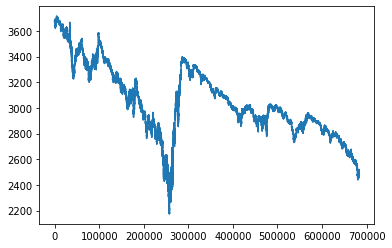

In [ ]:
plt.plot(df_usa['Open'])
plt.show();

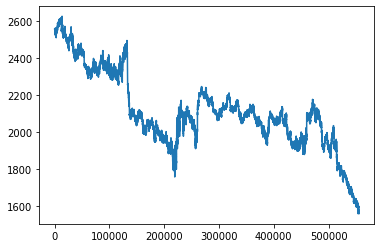

In [ ]:
plt.plot(df_china['close_usd'])
plt.show();

**OBSERVATION**
*  From the above plots, we can state that both the opening_price for USA and the closing_price for China follows a more or less similar trend but varies significantly in seasonality
*  We perform the Independent Student t-Test on both the groups for further analysis

## Performing Independent Student's t-Test

In [ ]:
def ind_student_t_test(sample_one, sample_two, alpha):
	
	mean_one, mean_two = np.mean(sample_one), np.mean(sample_two)	
	standard_error_one, standard_error_two = stats.sem(sample_one), stats.sem(sample_two)	
	standard_error_diff = np.sqrt(standard_error_one**2.0 + standard_error_two**2.0)	
	test_statistic = (mean_one - mean_two) / standard_error_diff
	
	degree_of_freedom = len(sample_one) + len(sample_two) - 2
	
	critical_value = stats.t.ppf(1.0 - alpha, degree_of_freedom)
	
	p_value = (1.0 - stats.t.cdf(abs(test_statistic), degree_of_freedom)) * 2.0
	
	return test_statistic, degree_of_freedom, critical_value, p_value

In [ ]:
sample_one = np.array(df_usa[['Open']].sample(100))
sample_two = np.array(df_china[['close_usd']].sample(100))
alpha = 0.05

In [ ]:
test_statistic, degree_of_freedom, critical_value, p_value = ind_student_t_test(sample_one, sample_two, alpha)
print('test_statistic=%.3f, degree_of_freedom=%d, critical_value=%.3f, p_value=%.3f' % (test_statistic, degree_of_freedom, 
                                                                                        critical_value, p_value))

test_statistic=27.155, degree_of_freedom=198, critical_value=1.653, p_value=0.000


In [ ]:
if abs(test_statistic) <= critical_value:
	print('Accept the null hypothesis that the means are equal.')
else:
  if p_value > alpha:
    print('Accept the null hypothesis that the means are equal.')
  else:
	  print('Reject the null hypothesis that the means are equal.')

Reject the null hypothesis that the means are equal.


**OBSERVATION**
*  From the above analysis, we can conclude that since the absolute value of the test-statistic is greater than the critical-value, so before rejecting the null-hypothesis we check the p-value and have observed that the p-value is less than the significance-level (alpha)
*  As such, we can reject the null hypothesis that the means of the two samples are equal and can finally conclude that the two samples are significantly different

## Performing Time-Based Splitting

In [ ]:
df_china.head()

,Date,Time,Volume,Open,High,Low,Close,close_usd
555712,2019-01-01,20:01:00,668,10435.0,10440.0,10410.0,10435.0,1594.005866
555711,2019-01-01,20:02:00,191,10435.0,10440.0,10432.5,10437.5,1594.387755
555710,2019-01-01,20:03:00,200,10435.0,10437.5,10430.0,10435.0,1594.005866
555709,2019-01-01,20:04:00,189,10435.0,10435.0,10425.0,10427.5,1592.860198
555708,2019-01-01,20:05:00,176,10427.5,10430.0,10425.0,10427.5,1592.860198


In [ ]:
df_china.tail()

,Date,Time,Volume,Open,High,Low,Close,close_usd
4,2020-12-15,10:12:00,3,16750.0,16750.0,16750.0,16750.0,2558.658194
3,2020-12-15,10:13:00,5,16748.0,16750.0,16748.0,16750.0,2558.658194
2,2020-12-15,10:14:00,7,16749.0,16752.0,16749.0,16750.0,2558.658194
1,2020-12-15,10:15:00,18,16752.0,16755.0,16752.0,16753.0,2559.116461
0,2020-12-15,10:16:00,12,16753.0,16753.0,16750.0,16751.0,2558.810950


**OBSERVATION**
*  Here we observe that each row of data is collected after every 1 minute from January 1, 2019 to December 15, 2020
*  For training our model, we shall only be considering the close_column of the dataset FTSEChinaA50

In [ ]:
train_size = int(len(df_china['Close']) * 0.8)
train_set = df_china['Close'][0:train_size]
test_set = df_china['Close'][train_size:len(df_china['Close'])]

In [ ]:
print("train.shape:", train_set.shape)
print("test.shape:", test_set.shape)

train.shape: (444570,)
test.shape: (111143,)


## Normalizing the Data

In [ ]:
normalizer = preprocessing.MinMaxScaler(feature_range=(0,1))
train_norm = normalizer.fit_transform(np.array(train_set).reshape(-1,1))
test_norm = normalizer.transform(np.array(test_set).reshape(-1,1))

## Performing Featurization using Moving-Window Technique

In [ ]:
def create_featurization(dataset, timestep):

  X_dataset, y_dataset = [], []
  for i in range(len(dataset)-timestep-1):
    features = dataset[i:(i+timestep), 0]
    X_dataset.append(features)
    y_dataset.append(dataset[(i+timestep), 0])
  return np.array(X_dataset), np.array(y_dataset)

In [ ]:
timestep = 100
X_train, y_train = create_featurization(train_norm, timestep)
X_test, y_test = create_featurization(test_norm, timestep)

In [ ]:
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_test.shape)

X_train.shape:  (444469, 100)
y_train.shape:  (444469,)
X_test.shape:  (111042, 100)
y_test.shape:  (111042,)


In [ ]:
# pickle.dump((X_train, y_train, X_test, y_test, normalizer), open('/content/gdrive/MyDrive/skanestas/data_dump.pkl', 'wb'))

## Reshaping Data for LSTM

In [ ]:
X_train_3d = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_3d = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
print('X_train_3d.shape: ', X_train_3d.shape)
print('X_test_3d.shape: ', X_test_3d.shape)

X_train_3d.shape:  (444469, 100, 1)
X_test_3d.shape:  (111042, 100, 1)


## Building a Stacked LSTM Model

In [ ]:
model = models.Sequential()
model.add(layers.LSTM(200, return_sequences=True, input_shape=(100, 1), name='lstm_layer_1'))
model.add(layers.LSTM(100, return_sequences=True, name='lstm_layer_2'))
model.add(layers.LSTM(50, name='lstm_layer_3'))
model.add(layers.Dropout(rate=0.6, name='dropout_layer_1'))
model.add(layers.Dense(1, name='output_layer'))

In [ ]:
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss='mean_squared_error')

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_layer_1 (LSTM)          (None, 100, 200)          161600    
_________________________________________________________________
lstm_layer_2 (LSTM)          (None, 100, 100)          120400    
_________________________________________________________________
lstm_layer_3 (LSTM)          (None, 50)                30200     
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 50)                0         
_________________________________________________________________
output_layer (Dense)         (None, 1)                 51        
Total params: 312,251
Trainable params: 312,251
Non-trainable params: 0
_________________________________________________________________


## Defining Callbacks

In [ ]:
filepath = "/content/gdrive/MyDrive/skanestas/models/lstm_model_epochs:{epoch:03d}-val_loss:{val_loss:.6f}.hdf5"
checkpoint = callbacks.ModelCheckpoint(filepath, monitor="val_loss", save_best_only=True, verbose=1)

In [ ]:
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=4, verbose=1)

In [ ]:
callback_list = [checkpoint, early_stopping]

## Training the Model

In [ ]:
print(tf.device('/device:GPU:0'))

In [ ]:
with tf.device('/device:GPU:0'):
  history = model.fit(X_train_3d, y_train, validation_data=(X_test_3d, y_test), epochs=100, batch_size=64, verbose=1, 
                      callbacks=callback_list)

Epoch 1/100
6945/6945 [==============================] - 133s 19ms/step - loss: 0.0104 - val_loss: 5.2102e-04

Epoch 00001: val_loss improved from inf to 0.00052, saving model to /content/gdrive/MyDrive/skanestas/models/lstm_model_epochs:001-val_loss:0.000521.hdf5
Epoch 2/100
6945/6945 [==============================] - 129s 19ms/step - loss: 0.0013 - val_loss: 4.2352e-04

Epoch 00002: val_loss improved from 0.00052 to 0.00042, saving model to /content/gdrive/MyDrive/skanestas/models/lstm_model_epochs:002-val_loss:0.000424.hdf5
Epoch 3/100
6945/6945 [==============================] - 129s 19ms/step - loss: 7.7097e-04 - val_loss: 4.0527e-04

Epoch 00003: val_loss improved from 0.00042 to 0.00041, saving model to /content/gdrive/MyDrive/skanestas/models/lstm_model_epochs:003-val_loss:0.000405.hdf5
Epoch 4/100
6945/6945 [==============================] - 129s 19ms/step - loss: 7.7158e-04 - val_loss: 2.9034e-04

Epoch 00004: val_loss improved from 0.00041 to 0.00029, saving model to /conte

In [ ]:
def plot_loss(history):  

  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label = 'val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(loc='upper right')

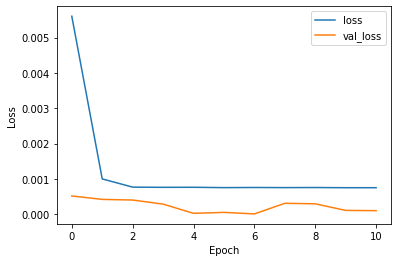

In [ ]:
plot_loss(history)

## Making Predictions

In [ ]:
X_train, y_train, X_test, y_test, normalizer = pickle.load(open('/content/gdrive/MyDrive/skanestas/data_dump.pkl', 'rb'))

In [ ]:
X_train_3d = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_3d = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
print('X_train_3d.shape: ', X_train_3d.shape)
print('y_train.shape: ', y_train.shape)
print('X_test_3d.shape: ', X_test_3d.shape)
print('y_test.shape: ', y_test.shape)

X_train_3d.shape:  (444469, 100, 1)
y_train.shape:  (444469,)
X_test_3d.shape:  (111042, 100, 1)
y_test.shape:  (111042,)


In [ ]:
best_model = models.load_model('/content/gdrive/MyDrive/skanestas/models/lstm_model_epochs:007-val_loss:0.000013.hdf5')

In [ ]:
y_train_predict = best_model.predict(X_train_3d)
y_test_predict = best_model.predict(X_test_3d)

In [ ]:
y_train_predict = normalizer.inverse_transform(y_train_predict)
y_test_predict = normalizer.inverse_transform(y_test_predict)

In [ ]:
def plot_act_v_pred(title, actual_set, predicted_set, color_list):
  
  plt.figure(figsize=(10,10))
  plt.title(title)
  plt.plot(normalizer.inverse_transform(actual_set.reshape(-1,1)), color=color_list[0], label='actual')
  plt.plot(predicted_set, color=color_list[1], label='predicted')
  plt.legend(loc='lower right')
  plt.show()

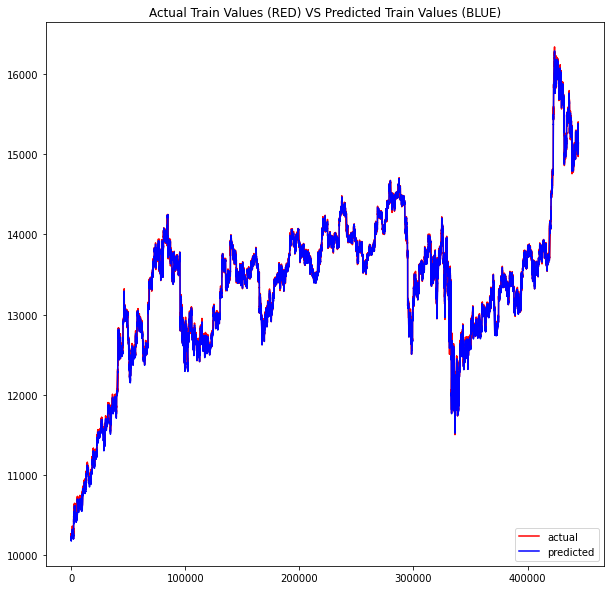

In [ ]:
title = 'Actual Train Values (RED) VS Predicted Train Values (BLUE)'
color_list = ['red', 'blue']
plot_act_v_pred(title, y_train, y_train_predict, color_list)

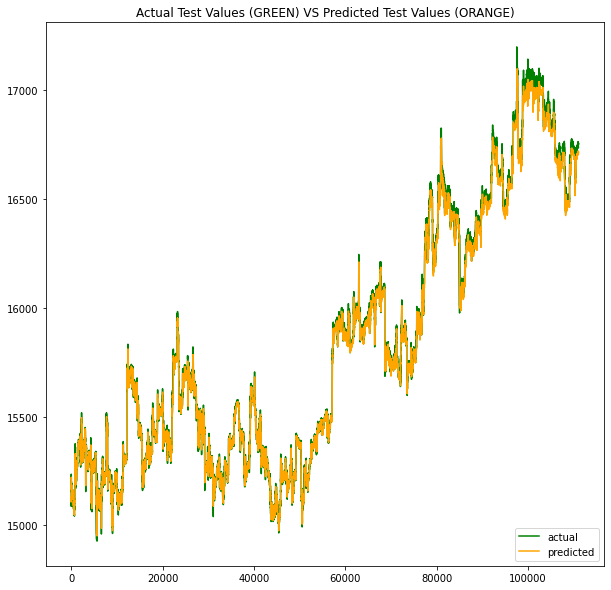

In [ ]:
title = 'Actual Test Values (GREEN) VS Predicted Test Values (ORANGE)'
color_list = ['green', 'orange']
plot_act_v_pred(title, y_test, y_test_predict, color_list)